# To recreate the model, calibration and results reported in the paper: Machine learning reduced workload with minimal risk of missing studies: development and evaluation of a COVID-19 research classifier for the Cochrane COVID-19 Study Register
N.B. very slight variation is to be expected due to running in a different environment and the fact that RIS files are used here rather than reading text from the database.


In [1]:
# import ris files

from RISparser import readris

TrainingIncludes = readris(open('1_Training_Included_20878.ris.txt', 'r', encoding="utf-8"))
TrainingExcludes = readris(open('2_Training_Excluded_38635.ris.txt', 'r', encoding="utf-8"))
CalibrationIncludes = readris(open('3_Calibration_Included_6005.ris.txt', 'r', encoding="utf-8"))
CalibrationExcludes = readris(open('4_Calibration_Excluded_10118.ris.txt', 'r', encoding="utf-8"))
EvaluationIncludes = readris(open('5_Evaluation_Included_2310.ris.txt', 'r', encoding="utf-8"))
EvaluationExcludes = readris(open('6_Evaluation_Excluded_2412.ris.txt', 'r', encoding="utf-8"))

In [2]:
# read data into dataframes (this can take a few minutes)

import pandas as pd

def parseData(incl, excl):
    data = pd.DataFrame(columns=['title', 'abstract', 'label'])
    for l in incl:
        title = ''
        abstract = ''
        if 'abstract' in l:
            abstract = l['abstract']
        if 'primary_title' in l:
            title = l['primary_title']
        data = data.append({'title': title, 'abstract': abstract, 'label': 1}, ignore_index=True)
    for l in excl:
        title = ''
        abstract = ''
        if 'abstract' in l:
            abstract = l['abstract']
        if 'primary_title' in l:
            title = l['primary_title']
        data = data.append({'title': title, 'abstract': abstract, 'label': 0}, ignore_index=True)
    data.abstract = data.abstract.fillna('none')
    data.title = data.title.fillna('none')
    data.reset_index(inplace=True)
    return data

TrainingDf = parseData(TrainingIncludes, TrainingExcludes)
CalibrationDf = parseData(CalibrationIncludes, CalibrationExcludes)
EvaluationDf = parseData(EvaluationIncludes, EvaluationExcludes)

In [3]:
# build model

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, GroupKFold, StratifiedKFold

def getFeatures(data):
    all_features = []
    for index in range(len(data)):
        title_tokens = data.title[index]
        abstract_tokens = data.abstract[index]        
        features = ["t_%s" % t for t in title_tokens.split(" ") if not t in stopwords]      
        features2 = ["a_%s" % t for t in abstract_tokens.split(" ") if not t in stopwords]
        features.extend(features2)
        all_features.append(" ".join(features))
    return all_features

stopwords = pd.read_csv('pubmed.stoplist.csv')
ids = TrainingDf.index.tolist()
labels = TrainingDf.label.astype(int)
training_features = getFeatures(TrainingDf)

vec = TfidfVectorizer(ngram_range=(1,3), max_features=75000, min_df=3, strip_accents='unicode')
X = vec.fit_transform(training_features)

sgd = SGDClassifier(class_weight="balanced", loss="log")
parameters = {'alpha':10.0**-np.arange(1,7)}
clf = GridSearchCV(sgd, parameters, scoring="roc_auc", cv=StratifiedKFold(n_splits=2))
clf.fit(X, labels)

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight='balanced',
                                     early_stopping=False, epsilon=0.1,
                                     eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='log', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-

In [4]:
# score calibration and test data

#vec2 = TfidfVectorizer(vocabulary=vec.get_feature_names(), ngram_range=(1,3), max_features=75000, min_df=3)

calibration_features = getFeatures(CalibrationDf)
evaluation_features = getFeatures(EvaluationDf)

X_calibration = vec.transform(calibration_features)
X_evaluation = vec.transform(evaluation_features)

calibration_preds = clf.predict_proba(X_calibration)
calibration_probabilities = calibration_preds[:,1]

evaluation_preds = clf.predict_proba(X_evaluation)
evaluation_probabilities = evaluation_preds[:,1]

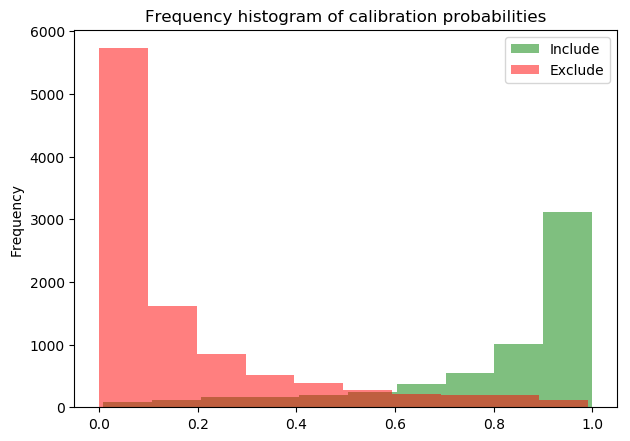

In [5]:
# plot calibration distribution

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

CalibrationDf['probabilities'] = calibration_probabilities

x1 = CalibrationDf.loc[CalibrationDf.label==1, 'probabilities']
x2 = CalibrationDf.loc[CalibrationDf.label==0, 'probabilities']

kwargs = dict(alpha=0.5, bins=10, stacked=True)

plt.hist(x1, **kwargs, color='g', label='Include')
plt.hist(x2, **kwargs, color='r', label='Exclude')
plt.gca().set(title='Frequency histogram of calibration probabilities', ylabel='Frequency')

plt.legend();

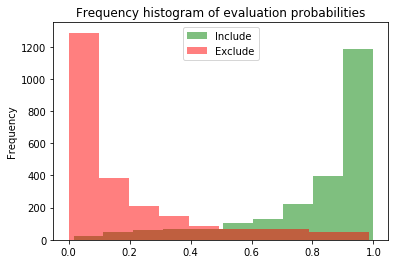

In [6]:
# plot evaluation distribution

EvaluationDf['probabilities'] = evaluation_probabilities

x1 = EvaluationDf.loc[EvaluationDf.label==1, 'probabilities']
x2 = EvaluationDf.loc[EvaluationDf.label==0, 'probabilities']

kwargs = dict(alpha=0.5, bins=10, stacked=True)

plt.hist(x1, **kwargs, color='g', label='Include')
plt.hist(x2, **kwargs, color='r', label='Exclude')
plt.gca().set(title='Frequency histogram of evaluation probabilities', ylabel='Frequency')

plt.legend();